# 🔧 Vibration Fault Detection - Signal Processing & ML Demo

This notebook demonstrates the complete pipeline for **predictive maintenance** using vibration signal analysis:

1. **Synthetic Signal Generation** - Create realistic vibration signatures for different fault conditions
2. **Signal Visualization** - Time-domain and frequency-domain analysis
3. **Feature Extraction** - Extract meaningful features for classification
4. **Machine Learning** - Train a RandomForest classifier for fault detection
5. **Model Export** - Save model for deployment in the FastAPI backend

---

## 🎯 Fault Types Covered
- **Normal** - Healthy machine operation
- **Unbalance** - Rotor mass imbalance (strong 1x component)
- **Misalignment** - Shaft misalignment (2x and 3x harmonics)
- **Bearing Fault** - Bearing degradation (high-frequency impacts)
- **Looseness** - Mechanical looseness (subharmonics and impulses)

In [1]:
# Install required packages (run once)
# !pip install numpy scipy scikit-learn matplotlib pandas joblib seaborn

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import detrend, windows, welch
from scipy.fft import rfft, rfftfreq
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import pandas as pd
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 5)
plt.rcParams['axes.facecolor'] = '#1a1a2e'
plt.rcParams['figure.facecolor'] = '#0f0f23'
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.alpha'] = 0.3

print("✓ All packages imported successfully!")

✓ All packages imported successfully!


## 1️⃣ Synthetic Signal Generation

We'll create realistic vibration signals that simulate different machine conditions. Each signal is composed of:
- **Fundamental frequency** (1x) - typically motor RPM
- **Harmonics** (2x, 3x, etc.) - multiples of fundamental
- **High-frequency components** - bearing defect frequencies
- **Noise** - random variations

In [2]:
# Signal generation parameters
SAMPLE_RATE = 2000  # Hz
DURATION = 1.0      # seconds
N_SAMPLES = int(SAMPLE_RATE * DURATION)
t = np.linspace(0, DURATION, N_SAMPLES)

def generate_signal(fault_type='Normal', seed=None):
    """
    Generate synthetic vibration signal for a given fault type.
    
    Parameters:
    -----------
    fault_type : str
        One of 'Normal', 'Unbalance', 'Misalignment', 'Bearing Fault', 'Looseness'
    seed : int, optional
        Random seed for reproducibility
    
    Returns:
    --------
    signal : np.ndarray
        Generated vibration signal
    """
    if seed is not None:
        np.random.seed(seed)
    
    # Base fundamental frequency (60 Hz = 3600 RPM motor)
    f1 = 60
    
    if fault_type == 'Normal':
        # Normal: Clean signal with minimal harmonics
        signal = 0.5 * np.sin(2 * np.pi * f1 * t)
        signal += 0.1 * np.sin(2 * np.pi * 2 * f1 * t)  # Small 2x
        signal += 0.05 * np.random.randn(N_SAMPLES)     # Low noise
        
    elif fault_type == 'Unbalance':
        # Unbalance: Strong 1x component
        signal = 1.2 * np.sin(2 * np.pi * f1 * t)       # Strong 1x
        signal += 0.2 * np.sin(2 * np.pi * 2 * f1 * t)  # Some 2x
        signal += 0.08 * np.random.randn(N_SAMPLES)
        
    elif fault_type == 'Misalignment':
        # Misalignment: Strong 2x and 3x harmonics
        signal = 0.4 * np.sin(2 * np.pi * f1 * t)
        signal += 0.8 * np.sin(2 * np.pi * 2 * f1 * t)  # Strong 2x
        signal += 0.5 * np.sin(2 * np.pi * 3 * f1 * t)  # Strong 3x
        signal += 0.1 * np.random.randn(N_SAMPLES)
        
    elif fault_type == 'Bearing Fault':
        # Bearing: High-frequency components + impulses
        signal = 0.4 * np.sin(2 * np.pi * f1 * t)
        signal += 0.3 * np.sin(2 * np.pi * 450 * t)     # BPFO-like
        signal += 0.2 * np.sin(2 * np.pi * 380 * t)     # BPFI-like
        # Add random impulses
        impulse_times = np.random.choice(N_SAMPLES, size=50, replace=False)
        impulses = np.zeros(N_SAMPLES)
        impulses[impulse_times] = np.random.randn(50) * 2.5
        signal += impulses
        signal += 0.15 * np.random.randn(N_SAMPLES)
        
    elif fault_type == 'Looseness':
        # Looseness: Subharmonics and many harmonics
        signal = 0.6 * np.sin(2 * np.pi * f1 * t)
        signal += 0.4 * np.sin(2 * np.pi * 0.5 * f1 * t)  # 0.5x subharmonic
        signal += 0.3 * np.sin(2 * np.pi * 2 * f1 * t)
        signal += 0.25 * np.sin(2 * np.pi * 3 * f1 * t)
        signal += 0.2 * np.sin(2 * np.pi * 4 * f1 * t)
        # Random impulses for mechanical looseness
        impulse_times = np.random.choice(N_SAMPLES, size=30, replace=False)
        impulses = np.zeros(N_SAMPLES)
        impulses[impulse_times] = np.random.randn(30) * 1.8
        signal += impulses
        signal += 0.12 * np.random.randn(N_SAMPLES)
    
    return signal

# Generate example signals
fault_types = ['Normal', 'Unbalance', 'Misalignment', 'Bearing Fault', 'Looseness']
example_signals = {ft: generate_signal(ft, seed=42) for ft in fault_types}

print("✓ Signal generator created")
print(f"  Sample rate: {SAMPLE_RATE} Hz")
print(f"  Duration: {DURATION} s")
print(f"  Samples per signal: {N_SAMPLES}")

✓ Signal generator created
  Sample rate: 2000 Hz
  Duration: 1.0 s
  Samples per signal: 2000


## 2️⃣ Visualize Raw Signals

Let's compare the time-domain characteristics of each fault type:

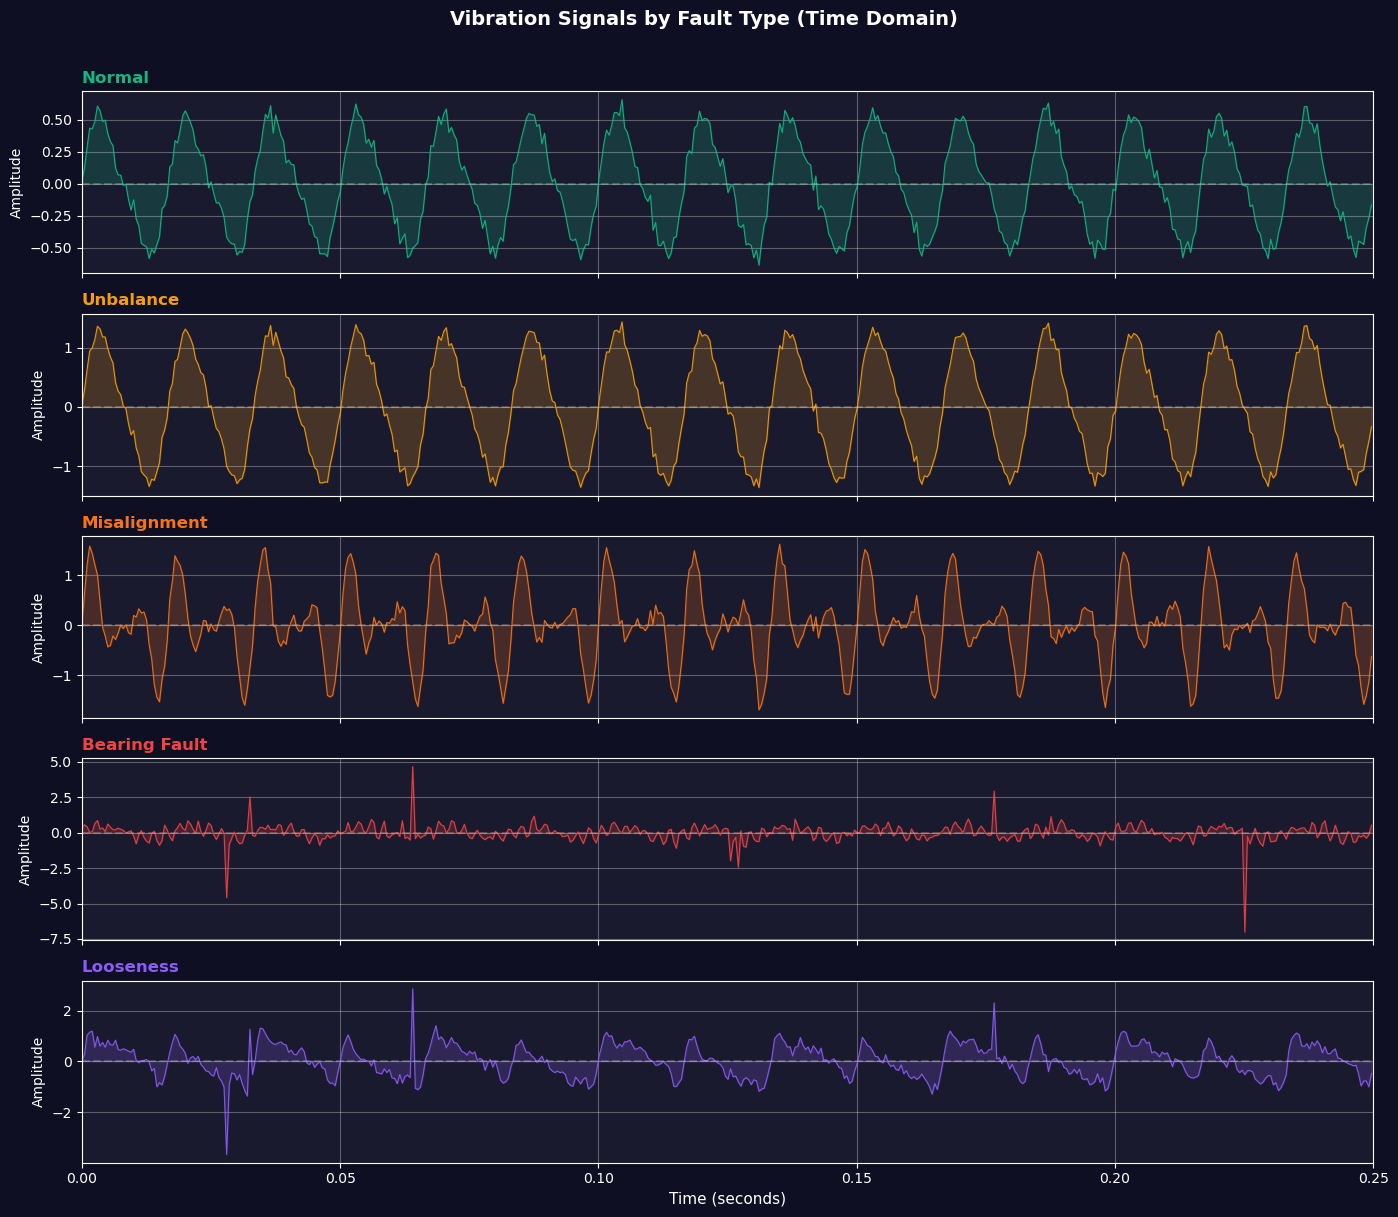


📊 Observations:
  • Normal: Clean periodic signal with low amplitude
  • Unbalance: High amplitude at fundamental frequency
  • Misalignment: Complex waveform with strong harmonics
  • Bearing Fault: Spiky impulses superimposed on signal
  • Looseness: Irregular pattern with subharmonics


In [3]:
# Plot all fault types
colors = ['#10B981', '#F59E0B', '#F97316', '#EF4444', '#8B5CF6']
fig, axes = plt.subplots(5, 1, figsize=(14, 12), sharex=True)

for ax, (fault_type, color) in zip(axes, zip(fault_types, colors)):
    sig = example_signals[fault_type]
    ax.plot(t[:500], sig[:500], color=color, linewidth=0.8, alpha=0.9)
    ax.fill_between(t[:500], sig[:500], alpha=0.2, color=color)
    ax.set_ylabel('Amplitude', fontsize=10)
    ax.set_title(f'{fault_type}', fontsize=12, fontweight='bold', color=color, loc='left')
    ax.set_xlim(0, 0.25)
    ax.axhline(y=0, color='white', alpha=0.2, linestyle='--')

axes[-1].set_xlabel('Time (seconds)', fontsize=11)
plt.suptitle('Vibration Signals by Fault Type (Time Domain)', fontsize=14, fontweight='bold', y=1.01)
plt.tight_layout()
plt.show()

print("\n📊 Observations:")
print("  • Normal: Clean periodic signal with low amplitude")
print("  • Unbalance: High amplitude at fundamental frequency")
print("  • Misalignment: Complex waveform with strong harmonics")
print("  • Bearing Fault: Spiky impulses superimposed on signal")
print("  • Looseness: Irregular pattern with subharmonics")

## 3️⃣ Frequency Domain Analysis (FFT & PSD)

The frequency spectrum reveals the **harmonic content** of each signal, which is key for fault diagnosis:

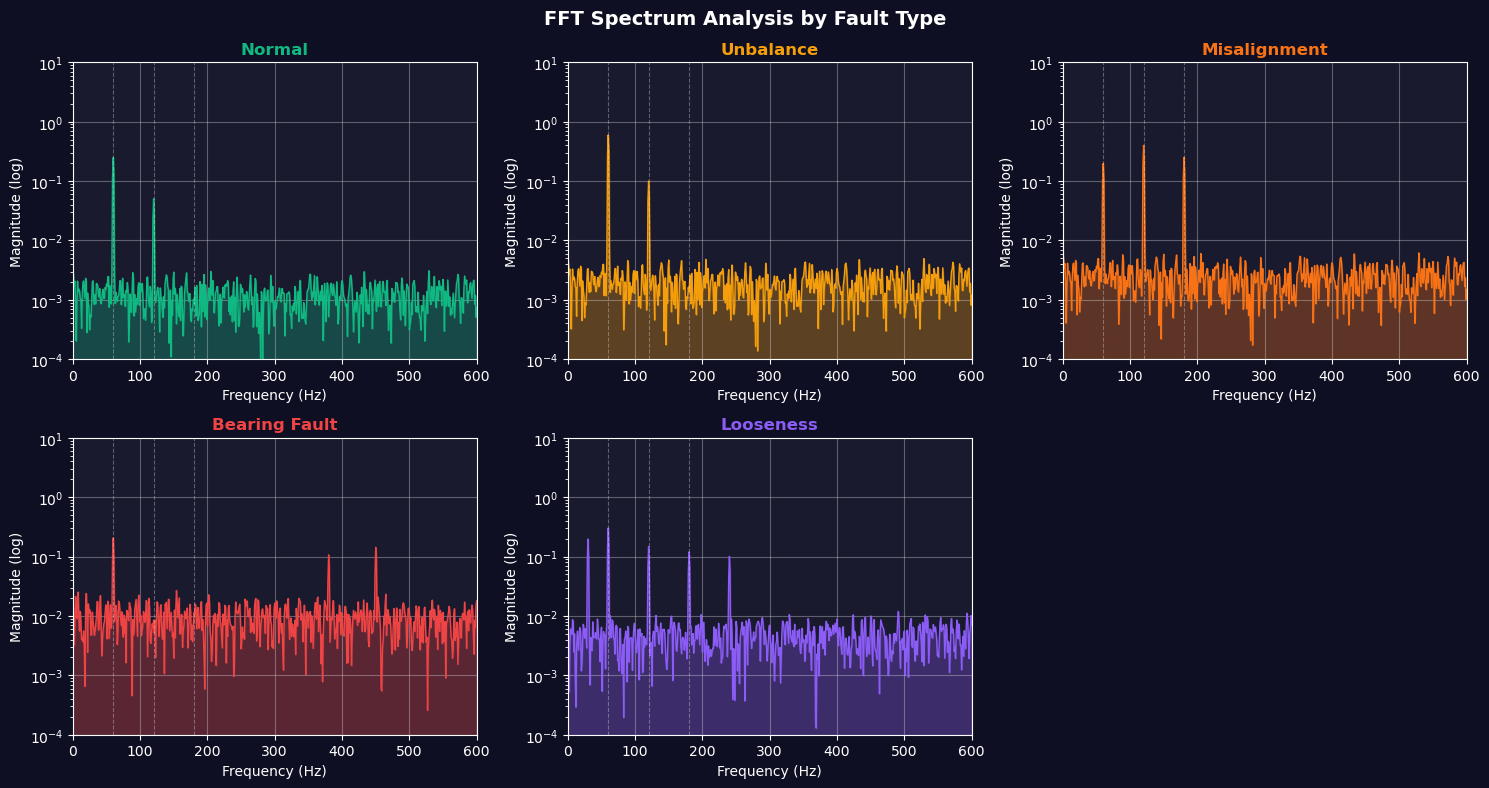


🔍 Frequency Analysis Insights:
  • Normal: Dominant 1x (60 Hz) with minimal harmonics
  • Unbalance: Very strong 1x peak
  • Misalignment: Strong 2x (120 Hz) and 3x (180 Hz)
  • Bearing: High-frequency content (350-500 Hz)
  • Looseness: Multiple harmonics + subharmonics


In [4]:
def compute_fft(signal, sample_rate=SAMPLE_RATE):
    """Compute FFT with proper normalization"""
    N = len(signal)
    # Apply Hanning window to reduce spectral leakage
    windowed = signal * windows.hann(N)
    yf = np.abs(rfft(windowed)) * 2 / N
    xf = rfftfreq(N, 1 / sample_rate)
    return xf, yf

def compute_psd(signal, sample_rate=SAMPLE_RATE):
    """Compute Power Spectral Density using Welch's method"""
    freqs, psd = welch(signal, fs=sample_rate, nperseg=min(256, len(signal)//4))
    return freqs, psd

# Plot FFT for all fault types
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for idx, (fault_type, color) in enumerate(zip(fault_types, colors)):
    ax = axes[idx]
    sig = example_signals[fault_type]
    xf, yf = compute_fft(sig)
    
    # Plot only up to 600 Hz
    mask = xf <= 600
    ax.semilogy(xf[mask], yf[mask] + 1e-6, color=color, linewidth=1)
    ax.fill_between(xf[mask], yf[mask] + 1e-6, 1e-6, alpha=0.3, color=color)
    ax.set_title(fault_type, fontsize=12, fontweight='bold', color=color)
    ax.set_xlabel('Frequency (Hz)', fontsize=10)
    ax.set_ylabel('Magnitude (log)', fontsize=10)
    ax.set_xlim(0, 600)
    ax.set_ylim(1e-4, 10)
    
    # Mark harmonic frequencies
    f1 = 60
    for n, label in [(1, '1x'), (2, '2x'), (3, '3x')]:
        ax.axvline(x=n*f1, color='white', alpha=0.3, linestyle='--', linewidth=0.8)

# Remove empty subplot
axes[-1].axis('off')

plt.suptitle('FFT Spectrum Analysis by Fault Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🔍 Frequency Analysis Insights:")
print("  • Normal: Dominant 1x (60 Hz) with minimal harmonics")
print("  • Unbalance: Very strong 1x peak")
print("  • Misalignment: Strong 2x (120 Hz) and 3x (180 Hz)")
print("  • Bearing: High-frequency content (350-500 Hz)")
print("  • Looseness: Multiple harmonics + subharmonics")

## 4️⃣ Feature Extraction

We extract statistical and spectral features that characterize each fault type:

In [5]:
def extract_features(signal, sample_rate=SAMPLE_RATE):
    """
    Extract comprehensive features from vibration signal.
    
    Returns dictionary with time-domain and frequency-domain features.
    """
    x = np.array(signal)
    xf, yf = compute_fft(x, sample_rate)
    
    # Time-domain features
    rms = np.sqrt(np.mean(x ** 2))
    peak = np.max(np.abs(x))
    crest_factor = peak / (rms + 1e-9)
    
    mean_x = x.mean()
    std_x = np.std(x) + 1e-9
    kurtosis = np.mean(((x - mean_x) / std_x) ** 4)
    skewness = np.mean(((x - mean_x) / std_x) ** 3)
    shape_factor = rms / (np.mean(np.abs(x)) + 1e-9)
    
    # Frequency-domain features
    yf_norm = yf / (np.sum(yf) + 1e-12)
    
    # Dominant frequency
    dominant_freq = xf[np.argmax(yf)]
    
    # Spectral centroid
    spectral_centroid = np.sum(xf * yf) / (np.sum(yf) + 1e-12)
    
    # Spectral entropy
    spectral_entropy = -np.sum(yf_norm * np.log(yf_norm + 1e-12))
    
    # Band energies
    low_mask = (xf >= 10) & (xf < 100)
    mid_mask = (xf >= 100) & (xf < 500)
    high_mask = xf >= 500
    
    total_energy = np.sum(yf ** 2) + 1e-12
    low_freq_ratio = np.sum(yf[low_mask] ** 2) / total_energy
    mid_freq_ratio = np.sum(yf[mid_mask] ** 2) / total_energy
    high_freq_ratio = np.sum(yf[high_mask] ** 2) / total_energy
    
    return {
        'rms': rms,
        'peak': peak,
        'crest_factor': crest_factor,
        'kurtosis': kurtosis,
        'skewness': skewness,
        'shape_factor': shape_factor,
        'dominant_freq': dominant_freq,
        'spectral_centroid': spectral_centroid,
        'spectral_entropy': spectral_entropy,
        'low_freq_ratio': low_freq_ratio,
        'mid_freq_ratio': mid_freq_ratio,
        'high_freq_ratio': high_freq_ratio
    }

# Extract features for example signals
feature_table = []
for fault_type in fault_types:
    feats = extract_features(example_signals[fault_type])
    feats['fault_type'] = fault_type
    feature_table.append(feats)

df_features = pd.DataFrame(feature_table)
df_features = df_features.set_index('fault_type')

# Display feature comparison
print("📊 Feature Comparison by Fault Type:\n")
print(df_features.round(4).T.to_string())

📊 Feature Comparison by Fault Type:

fault_type           Normal  Unbalance  Misalignment  Bearing Fault  Looseness
rms                  0.3628     0.8619        0.7305         0.5690     0.6358
peak                 0.6601     1.4561        1.7105         7.0157     3.6620
crest_factor         1.8196     1.6893        2.3415        12.3308     5.7597
kurtosis             1.6615     1.6024        2.9663        31.3093     3.2815
skewness            -0.0014    -0.0005       -0.0181        -0.3001    -0.0834
shape_factor         1.1362     1.1273        1.3581         1.5006     1.1981
dominant_freq       60.0000    60.0000      120.0000        60.0000    60.0000
spectral_centroid  358.1673   319.5306      345.0546       474.7005   391.8492
spectral_entropy     5.6637     5.2278        5.5222         6.6390     6.1744
low_freq_ratio       0.9439     0.9647        0.1475         0.3301     0.6794
mid_freq_ratio       0.0461     0.0307        0.8427         0.4293     0.2741
high_freq_ratio

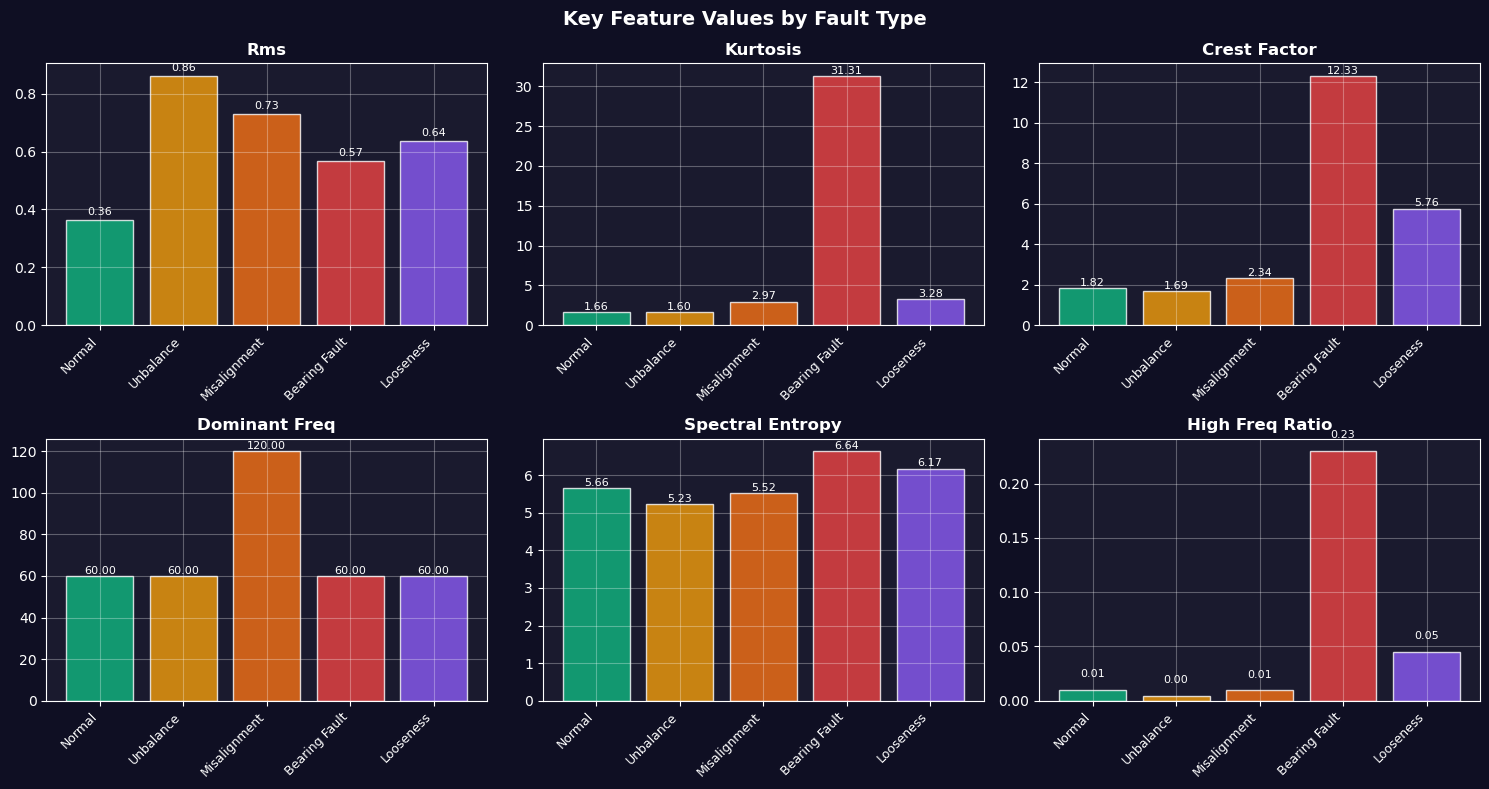


🎯 Key Feature Insights:
  • Bearing faults → High kurtosis (impulsiveness)
  • Unbalance → High RMS amplitude
  • Misalignment → Higher spectral entropy (complex spectrum)
  • Bearing → High-frequency energy ratio


In [6]:
# Visualize feature distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

key_features = ['rms', 'kurtosis', 'crest_factor', 'dominant_freq', 'spectral_entropy', 'high_freq_ratio']

for idx, feature in enumerate(key_features):
    ax = axes[idx]
    values = df_features[feature].values
    bars = ax.bar(fault_types, values, color=colors, alpha=0.8, edgecolor='white', linewidth=1)
    ax.set_title(feature.replace('_', ' ').title(), fontsize=12, fontweight='bold')
    ax.set_xticklabels(fault_types, rotation=45, ha='right', fontsize=9)
    
    # Add value labels
    for bar, val in zip(bars, values):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{val:.2f}', ha='center', va='bottom', fontsize=8, color='white')

plt.suptitle('Key Feature Values by Fault Type', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🎯 Key Feature Insights:")
print("  • Bearing faults → High kurtosis (impulsiveness)")
print("  • Unbalance → High RMS amplitude")
print("  • Misalignment → Higher spectral entropy (complex spectrum)")
print("  • Bearing → High-frequency energy ratio")

## 5️⃣ Generate Training Dataset

Create a larger dataset with multiple samples per fault type for ML training:

In [7]:
# Generate training dataset
N_SAMPLES_PER_CLASS = 200  # 200 samples per fault type
dataset = []

print("🔄 Generating training dataset...")
for fault_type in fault_types:
    for i in range(N_SAMPLES_PER_CLASS):
        signal = generate_signal(fault_type, seed=i*10 + fault_types.index(fault_type))
        features = extract_features(signal)
        features['label'] = fault_type
        dataset.append(features)
        
        if (i + 1) % 50 == 0:
            print(f"   {fault_type}: {i+1}/{N_SAMPLES_PER_CLASS}")

df = pd.DataFrame(dataset)
print(f"\n✓ Dataset created: {len(df)} samples, {len(df.columns)-1} features")
print(f"  Classes: {df['label'].value_counts().to_dict()}")

# Prepare features and labels
feature_cols = [c for c in df.columns if c != 'label']
X = df[feature_cols].values
y = df['label'].values

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print(f"\n📊 Train/Test split:")
print(f"   Training: {len(X_train)} samples")
print(f"   Testing: {len(X_test)} samples")

🔄 Generating training dataset...
   Normal: 50/200
   Normal: 100/200
   Normal: 150/200
   Normal: 200/200
   Unbalance: 50/200
   Unbalance: 100/200
   Unbalance: 150/200
   Unbalance: 200/200
   Misalignment: 50/200
   Misalignment: 100/200
   Misalignment: 150/200
   Misalignment: 200/200
   Unbalance: 50/200
   Unbalance: 100/200
   Unbalance: 150/200
   Unbalance: 200/200
   Misalignment: 50/200
   Misalignment: 100/200
   Misalignment: 150/200
   Misalignment: 200/200
   Bearing Fault: 50/200
   Bearing Fault: 100/200
   Bearing Fault: 150/200
   Bearing Fault: 200/200
   Looseness: 50/200
   Looseness: 100/200
   Looseness: 150/200
   Looseness: 200/200

✓ Dataset created: 1000 samples, 12 features
  Classes: {'Normal': 200, 'Unbalance': 200, 'Misalignment': 200, 'Bearing Fault': 200, 'Looseness': 200}

📊 Train/Test split:
   Training: 800 samples
   Testing: 200 samples
   Bearing Fault: 50/200
   Bearing Fault: 100/200
   Bearing Fault: 150/200
   Bearing Fault: 200/200
   Lo

## 6️⃣ Train RandomForest Classifier

Train and evaluate a machine learning model for fault classification:

In [8]:
# Train RandomForest classifier
print("🌲 Training RandomForest classifier...")
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

model.fit(X_train, y_train)

# Cross-validation
cv_scores = cross_val_score(model, X_train, y_train, cv=5)
print(f"\n📈 Cross-validation scores: {cv_scores.round(3)}")
print(f"   Mean CV accuracy: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Test set evaluation
y_pred = model.predict(X_test)
test_accuracy = (y_pred == y_test).mean()
print(f"\n🎯 Test set accuracy: {test_accuracy:.3f}")

# Classification report
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

🌲 Training RandomForest classifier...

📈 Cross-validation scores: [1. 1. 1. 1. 1.]
   Mean CV accuracy: 1.000 ± 0.000

🎯 Test set accuracy: 1.000

📋 Classification Report:
               precision    recall  f1-score   support

Bearing Fault       1.00      1.00      1.00        40
    Looseness       1.00      1.00      1.00        40
 Misalignment       1.00      1.00      1.00        40
       Normal       1.00      1.00      1.00        40
    Unbalance       1.00      1.00      1.00        40

     accuracy                           1.00       200
    macro avg       1.00      1.00      1.00       200
 weighted avg       1.00      1.00      1.00       200


📈 Cross-validation scores: [1. 1. 1. 1. 1.]
   Mean CV accuracy: 1.000 ± 0.000

🎯 Test set accuracy: 1.000

📋 Classification Report:
               precision    recall  f1-score   support

Bearing Fault       1.00      1.00      1.00        40
    Looseness       1.00      1.00      1.00        40
 Misalignment       1.00      

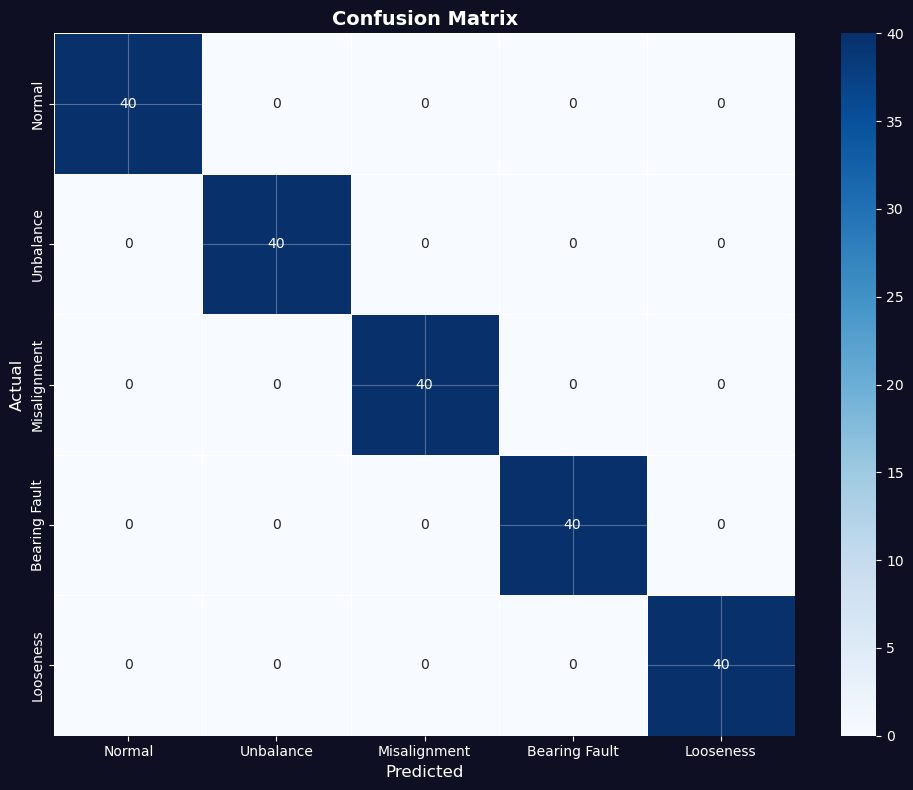

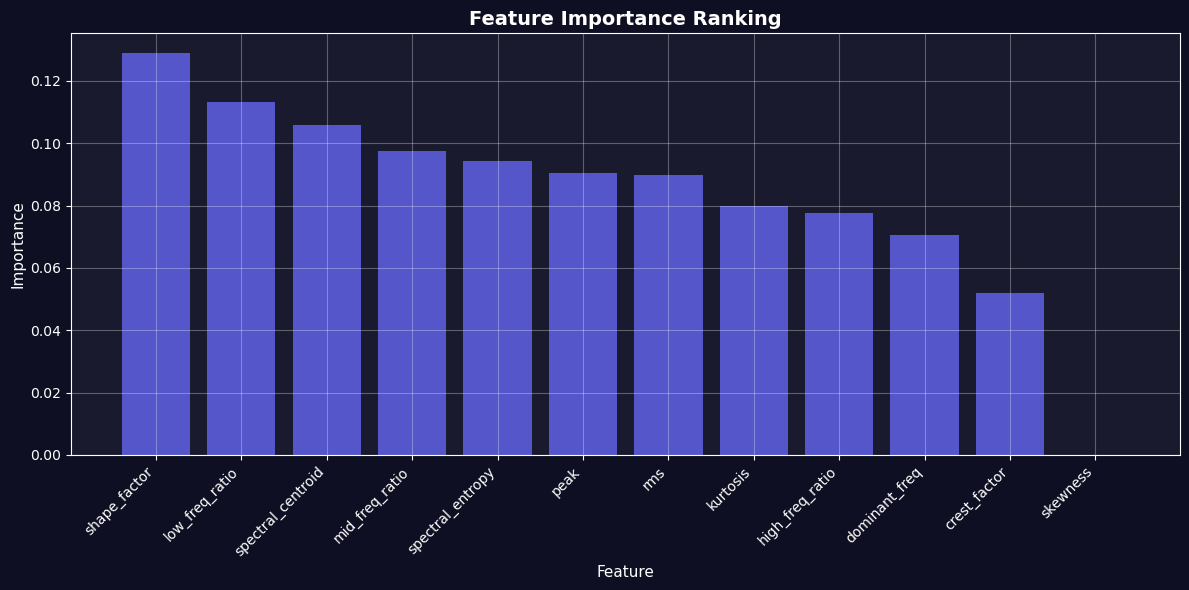


🏆 Top 5 Most Important Features:
   1. shape_factor: 0.1288
   2. low_freq_ratio: 0.1132
   3. spectral_centroid: 0.1058
   4. mid_freq_ratio: 0.0975
   5. spectral_entropy: 0.0943


In [9]:
# Confusion matrix visualization
fig, ax = plt.subplots(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred, labels=fault_types)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=fault_types, yticklabels=fault_types, ax=ax,
            linewidths=0.5, linecolor='white')
ax.set_xlabel('Predicted', fontsize=12)
ax.set_ylabel('Actual', fontsize=12)
ax.set_title('Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Feature importance
importances = model.feature_importances_
indices = np.argsort(importances)[::-1]

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(range(len(importances)), importances[indices], color='#6366f1', alpha=0.8)
ax.set_xticks(range(len(importances)))
ax.set_xticklabels([feature_cols[i] for i in indices], rotation=45, ha='right')
ax.set_xlabel('Feature', fontsize=11)
ax.set_ylabel('Importance', fontsize=11)
ax.set_title('Feature Importance Ranking', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\n🏆 Top 5 Most Important Features:")
for i in range(5):
    print(f"   {i+1}. {feature_cols[indices[i]]}: {importances[indices[i]]:.4f}")

## 7️⃣ Save Model & Sample Data

Export the trained model and create sample CSV files for testing:

In [10]:
# Create directories
model_dir = Path('../backend/models')
samples_dir = Path('../samples')
model_dir.mkdir(parents=True, exist_ok=True)
samples_dir.mkdir(parents=True, exist_ok=True)

# Save model
model_path = model_dir / 'demo_model.pkl'
joblib.dump(model, model_path)
print(f"✓ Model saved to: {model_path}")

# Save feature column names for inference
metadata = {
    'feature_columns': feature_cols,
    'fault_types': fault_types,
    'sample_rate': SAMPLE_RATE
}
joblib.dump(metadata, model_dir / 'model_metadata.pkl')
print(f"✓ Metadata saved to: {model_dir / 'model_metadata.pkl'}")

# Generate and save sample CSV files for each fault type
print("\n📁 Creating sample CSV files...")
for fault_type in fault_types:
    signal = generate_signal(fault_type, seed=999)
    filename = f"sample_{fault_type.lower().replace(' ', '_')}.csv"
    filepath = samples_dir / filename
    np.savetxt(filepath, signal, delimiter=',', fmt='%.6f')
    print(f"   ✓ {filename} ({len(signal)} samples)")

print(f"\n🎉 All files saved! Check the following locations:")
print(f"   Model: {model_path.resolve()}")
print(f"   Samples: {samples_dir.resolve()}")

✓ Model saved to: ..\backend\models\demo_model.pkl
✓ Metadata saved to: ..\backend\models\model_metadata.pkl

📁 Creating sample CSV files...
   ✓ sample_normal.csv (2000 samples)
   ✓ sample_unbalance.csv (2000 samples)
   ✓ sample_misalignment.csv (2000 samples)
   ✓ sample_bearing_fault.csv (2000 samples)
   ✓ sample_looseness.csv (2000 samples)

🎉 All files saved! Check the following locations:
   Model: C:\Users\cezza\OneDrive\Desktop\assign2\fault-detect\backend\models\demo_model.pkl
   Samples: C:\Users\cezza\OneDrive\Desktop\assign2\fault-detect\samples


## 8️⃣ Test Model Prediction

Verify the model works correctly with a sample prediction:

In [11]:
# Load model and test prediction
loaded_model = joblib.load(model_path)
loaded_metadata = joblib.load(model_dir / 'model_metadata.pkl')

# Generate a test signal
test_fault = 'Bearing Fault'
test_signal = generate_signal(test_fault, seed=12345)
test_features = extract_features(test_signal)

# Prepare feature vector in correct order
feature_vector = np.array([[test_features[col] for col in loaded_metadata['feature_columns']]])

# Predict
prediction = loaded_model.predict(feature_vector)[0]
probabilities = loaded_model.predict_proba(feature_vector)[0]
confidence = max(probabilities)

print("🧪 Test Prediction:")
print(f"   Actual fault: {test_fault}")
print(f"   Predicted: {prediction}")
print(f"   Confidence: {confidence:.1%}")
print(f"\n   Class probabilities:")
for ft, prob in zip(loaded_metadata['fault_types'], probabilities):
    bar = '█' * int(prob * 20)
    print(f"   {ft:15s}: {bar:20s} {prob:.1%}")

🧪 Test Prediction:
   Actual fault: Bearing Fault
   Predicted: Bearing Fault
   Confidence: 100.0%

   Class probabilities:
   Normal         : ████████████████████ 100.0%
   Unbalance      :                      0.0%
   Misalignment   :                      0.0%
   Bearing Fault  :                      0.0%
   Looseness      :                      0.0%


---

## ✅ Summary

This notebook demonstrated:

1. **Signal Generation**: Created realistic synthetic vibration signals for 5 fault types
2. **Visualization**: Time-domain and frequency-domain analysis
3. **Feature Extraction**: 12 statistical and spectral features
4. **ML Training**: RandomForest classifier with cross-validation
5. **Model Export**: Saved model for use in FastAPI backend

### Next Steps:
- Run the FastAPI backend: `uvicorn app.main:app --reload`
- Start the React frontend: `npm run dev`
- Upload sample CSV files to test the complete system

### Files Created:
- `backend/models/demo_model.pkl` - Trained classifier
- `backend/models/model_metadata.pkl` - Feature metadata
- `samples/*.csv` - Sample signals for testing